In [1]:
import stepwise_regression.step_reg as step_reg
from pyCompare import blandAltman

from scipy.stats import pearsonr, spearmanr
from scipy.special import logit

from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
file_suffix = "_after_shift_p%02d.csv" % 80
%run load_connectivity_data.ipynb

Couldn't load Patient #3 data using file suffix: _after_shift_p80.csv
Couldn't load Patient #8 data using file suffix: _after_shift_p80.csv


In [3]:
patient_ids = [1, 4, 6, 7, 11, 12]
eval_patient_id = 10

all_patient_ids = patient_ids + [eval_patient_id]


In [4]:
macrostructural_conn_measures = [
    'streamlines_num', 'min_len', 'median_len', 'smoothwm_surf_dist'
]

microstructural_conn_measures = [
    'mean_fa', 'mean_md', 'mean_ad', 'mean_rd', 
    'mean_rtop', 'mean_rtpp', 'mean_msd', 'mean_qiv', 'ng', 'ng_perp', 'ng_par'
]

effective_conn_measures = [
    'p1_delay', 'p1_value'
]

In [5]:
def get_patient_data_set(patient_id, structural_conn, effective_conn):

    data_set = data_pd[patient_id].loc[np.abs(data_pd[patient_id][effective_conn]) > 0]

    input_variables = data_set[structural_conn]
    
    if 'streamlines_num' in structural_conn:
        input_variables['streamlines_num'] = -np.log10(1 + data_set[['streamlines_num']])
    
    if 'mean_rtop' in structural_conn:
        input_variables['mean_rtop'] = np.power(np.maximum(0, data_set[['mean_rtop']]), 1.0/3)
        
    if 'mean_rtap' in structural_conn:
        input_variables['mean_rtap'] = np.power(np.maximum(0, data_set[['mean_rtap']]), 1.0/2)
    
    output_variable = data_set[[effective_conn]]
    
    return input_variables, output_variable


def modify_data_for_amplitude(input_variables, output_variable, structural_conn):

    inverse_values = ['streamlines_num', 'min_len', 'median_len', 'smoothwm_surf_dist']
    
    for inverse_value in inverse_values:
        if inverse_value in structural_conn:
            input_variables[inverse_value] = 1.0 / (1 + input_variables[inverse_value])
            
    output_variable[['p1_value']] = np.sqrt(1e06 * np.abs(output_variable[['p1_value']]))

    return input_variables, output_variable 


def get_data_set(patient_ids, structural_conn, effective_conn = 'p1_delay'):

    input_variables_vector = []
    output_variable_vector = []
    
    for patient_id in patient_ids:
        x, y = get_patient_data_set(patient_id, structural_conn, effective_conn)
        
        if effective_conn == 'p1_value':
            x, y = modify_data_for_amplitude(x, y, structural_conn)
        
        input_variables_vector.append(x)
        output_variable_vector.append(y)
        
    return pd.concat(input_variables_vector), pd.concat(output_variable_vector)
        
    

In [6]:
def get_batch_patient_ids(eval_patient_id, patient_dataset_ids = all_patient_ids):

    train_test_patient_ids = patient_dataset_ids.copy() 
    train_test_patient_ids.remove(eval_patient_id)

    batch_patient_ids = []

    for test_patient_id in train_test_patient_ids:
        train_patient_ids = train_test_patient_ids.copy()
        train_patient_ids.remove(test_patient_id)
        batch_patient_ids.append([train_patient_ids, [test_patient_id]])

    return batch_patient_ids


In [7]:
def train_regression_model_of_delays(train_x, train_y, test_x, test_y):
    
    regr = linear_model.LinearRegression(normalize=True)
#     regr = svm.SVR(C=1.0, epsilon=0.2) # gamma='scale', C=1.0, epsilon=0.2)
#     regr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3)

    regr.fit(train_x, train_y)
    pred_y = regr.predict(test_x)
    
    regression_score = r2_score(test_y, pred_y)

    squared_error = (test_y - pred_y) ** 2
    dummy_squared_error = (test_y - np.mean(train_y)) ** 2

    aic = 2 * train_x.shape[1] + 2 * np.log(np.mean(squared_error))
    bic = np.log(len(test_y)) * train_x.shape[1] + 2 * np.log(np.mean(squared_error))
    
#     sns.distplot(np.sqrt(squared_error))

    rmse = np.sqrt(np.mean(squared_error))
    rmse_std = np.sqrt(np.std(squared_error))
    
    dummy_rmse = np.sqrt(np.mean(dummy_squared_error))
    dummy_rmse_std = np.sqrt(np.std(dummy_squared_error))
    
#     print("RMSE +/- STD = %.0f +/- %.1f\tdummy RMSE +/- STD = %.0f +/- %.1f" % (
#         rmse, rmse_std, dummy_rmse, dummy_rmse_std
#     ), end="\t")
    
    return [regression_score, rmse, rmse_std, dummy_rmse, dummy_rmse_std, aic, bic, regr.coef_[0], regr.intercept_], regr.coef_


In [8]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

In [9]:
def prediction_summary(effective_var):

    macro_only_coefs = []
    macro_only_intercepts = []
    macro_and_micro_intercepts = []

    macro_and_micro_coefs = {}


    # find a list of regressors

    forward_regression_vars = {}
    backward_regression_vars = {}

    for i in range(len(macrostructural_conn_measures)):
        macrostructural_conn_measure = macrostructural_conn_measures[i]

        x, y = get_data_set(
            patient_ids, 
            [macrostructural_conn_measure] + microstructural_conn_measures, 
            effective_var
        )

#         x, y = get_data_set(
#             patient_ids, 
#             microstructural_conn_measures, 
#             effective_var
#         )

#         x, y = get_data_set(
#             patient_ids, 
#             ['mean_rtop', 'mean_rd'], 
#             effective_var
#         )
    
        forward_regression_vars[i] = step_reg.forward_regression(x, y, 0.25)
        backward_regression_vars[i] = step_reg.backward_regression(x, y, 0.25)


    for batch in get_batch_patient_ids(eval_patient_id):

        print("\nTrained on Patients: %s, Tested on Patients: %s" % (sorted(batch[0]), sorted(batch[1])))

        macro_only_accuracy = []
        macro_and_micro_accuracy = []

        for i in range(len(macrostructural_conn_measures)):
            macrostructural_conn_measure = macrostructural_conn_measures[i]

            # macro only

            regression_vars = [macrostructural_conn_measure]
            train_x, train_y = get_data_set(batch[0], regression_vars, effective_var)
            test_x, test_y = get_data_set(batch[1], regression_vars, effective_var)

            result, _ = train_regression_model_of_delays(train_x.values, train_y.values, test_x.values, test_y.values)    
            result.append(str(regression_vars))
            macro_only_accuracy.append(result)

            # macro and micro

            regression_vars = forward_regression_vars[i]
            train_x, train_y = get_data_set(batch[0], regression_vars, effective_var)
            test_x, test_y = get_data_set(batch[1], regression_vars, effective_var)

            result, coefs = train_regression_model_of_delays(train_x.values, train_y.values, test_x.values, test_y.values)    
            result.append(str(regression_vars))
            macro_and_micro_accuracy.append(result)

            if i in macro_and_micro_coefs:
                macro_and_micro_coefs[i] = np.r_[macro_and_micro_coefs[i], coefs]
            else:
                macro_and_micro_coefs[i] = coefs

        macro_only_accuracy_df = pd.DataFrame(macro_only_accuracy, columns = [
            'score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'aic', 'bic', 'coef', 'intercept', 'features'
        ])
        print(macro_only_accuracy_df[['score', 'rmse', 'rmse_std', 'features']].round({'score': 2, 'rmse' : 0, 'rmse_std': 0, 'bic': 1}))

        macro_and_micro_accuracy_df = pd.DataFrame(macro_and_micro_accuracy, columns = [
            'score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'aic', 'bic', 'coef', 'intercept', 'features'
        ])
        print(macro_and_micro_accuracy_df[['score', 'rmse', 'rmse_std', 'features']].round({'score': 2, 'rmse' : 0, 'rmse_std': 0, 'bic': 1}))

        macro_only_coefs.append(macro_only_accuracy_df['coef'].values)
        macro_only_intercepts.append(macro_only_accuracy_df['intercept'].values)

        macro_and_micro_intercepts.append(macro_and_micro_accuracy_df['intercept'].values)


    print("\nEvaluated on Patient: %d" % eval_patient_id)

    mean_coefs = np.mean(np.array(macro_only_coefs), axis=0)
    mean_intercepts = np.mean(np.array(macro_only_intercepts), axis=0)

    # eval_x, eval_y = get_delay_features([eval_patient_id], input_variables)


    # plt.figure(figsize=(10, 10))
    # plt.suptitle("\nPrediction of P1 delays")


    # macro only

    print("score\trmse +/- std\tcoef\tintercept")

    fig, ax = plt.subplots(4, 2, figsize=(15, 30))

    for i in range(len(macrostructural_conn_measures)):

        macrostructural_conn_measure = macrostructural_conn_measures[i]

        regression_vars = [macrostructural_conn_measure]
        x, y = get_data_set([eval_patient_id], regression_vars, effective_var)
        eval_x = x.values
        eval_y = y.values

        regr = linear_model.LinearRegression(normalize=True)
        regr.coef_ = mean_coefs[i]
        regr.intercept_ = mean_intercepts[i]
        pred_y = np.ravel(regr.predict(eval_x.reshape(-1, 1)))

        squared_error = (np.squeeze(eval_y) - np.squeeze(pred_y)) ** 2
        print("%.2f\t%.0f +/- %.0f\t%s\t%s" % (
            regr.score(eval_x.reshape(-1, 1), eval_y), 
            np.sqrt(np.mean(squared_error)), 
            np.sqrt(np.std(squared_error)),
            regr.coef_, regr.intercept_
        ))

        fig.sca(ax[i, 0])
        bland_altman_plot(np.squeeze(pred_y), np.squeeze(eval_y))
        plt.title(regression_vars)
        plt.ylim([-30, 50])
        plt.xlabel("(PRED + TEST) / 2")
        plt.ylabel("PRED - TEST")



    #     blandAltman(np.squeeze(eval_y), np.squeeze(pred_y), detrend='ODR')

    #     plt.subplot(2, 2, i + 1)
    #     values = np.array([eval_y, pred_y])
    #     values.sort()
    #     plt.plot(values[0], linestyle="", marker="o", label="measured")
    #     plt.plot(values[1], linestyle="", marker="*", label="predicted (macro only)")


    # macro and micro

    mean_intercepts = np.mean(np.array(macro_and_micro_intercepts), axis=0)

    print("score\trmse +/- std\tcoef\tintercept")

    for i in range(len(macrostructural_conn_measures)):

        mean_coefs = np.mean(np.array(macro_and_micro_coefs[i]), axis=0)
        macrostructural_conn_measure = macrostructural_conn_measures[i]

        regression_vars = forward_regression_vars[i]
        x, y = get_data_set([eval_patient_id], regression_vars, effective_var)
        eval_x = x.values
        eval_y = y.values

        regr = linear_model.LinearRegression(normalize=True)
        regr.coef_ = mean_coefs
        regr.intercept_ = mean_intercepts[i]
        pred_y = np.ravel(regr.predict(eval_x))

        squared_error = (np.squeeze(eval_y) - np.squeeze(pred_y)) ** 2

        print("%.2f\t%.0f +/- %.0f\t%s\t%s" % (
            regr.score(eval_x, eval_y), 
            np.sqrt(np.mean(squared_error)), 
            np.sqrt(np.std(squared_error)),
            regr.coef_, regr.intercept_
        ))

        fig.sca(ax[i, 1])
        bland_altman_plot(np.squeeze(pred_y), np.squeeze(eval_y))
        plt.title(regression_vars)
        plt.ylim([-30, 50])
        plt.xlabel("(PRED + TEST) / 2")
        plt.ylabel("PRED - TEST")

    #     blandAltman(np.squeeze(eval_y), np.squeeze(pred_y))



    #     plt.subplot(2, 2, i + 1)
    #     values = np.array([eval_y, pred_y])
    #     values.sort()
    #     plt.plot(values[1], linestyle="", marker="d", label="predicted (macro & micro)")
    #     plt.xticks([])
    #     plt.legend()

    # plt.subplot(2, 2, 1)
    # plt.ylabel("P1 delays [ms]")
    # plt.title("(a) $-$log count")

    # plt.subplot(2, 2, 2)
    # plt.title("(b) min str")

    # plt.subplot(2, 2, 3)
    # plt.ylabel("P1 delays [ms]")
    # plt.title("(c) med str")

    # plt.subplot(2, 2, 4)
    # plt.title("(d) wm dist")

    plt.savefig("prediction_ba_plots_%s.png" % effective_var)


# Prediction of P1 delays


Trained on Patients: [4, 6, 7, 11, 12], Tested on Patients: [1]
   score  rmse  rmse_std                features
0  -0.19  10.0      11.0     ['streamlines_num']
1  -0.44  11.0      11.0             ['min_len']
2  -0.60  11.0      12.0          ['median_len']
3  -0.39  10.0      11.0  ['smoothwm_surf_dist']
   score  rmse  rmse_std                                           features
0  -0.01   9.0       9.0  ['streamlines_num', 'mean_qiv', 'mean_fa', 'me...
1  -0.36  10.0      11.0  ['min_len', 'mean_fa', 'mean_qiv', 'mean_msd',...
2  -0.31  10.0      11.0  ['mean_fa', 'mean_qiv', 'mean_msd', 'ng_perp',...
3  -0.20  10.0      11.0  ['smoothwm_surf_dist', 'mean_qiv', 'mean_fa', ...

Trained on Patients: [1, 6, 7, 11, 12], Tested on Patients: [4]
   score  rmse  rmse_std                features
0   0.29   8.0       9.0     ['streamlines_num']
1   0.16   8.0       9.0             ['min_len']
2   0.00   9.0      11.0          ['median_len']
3   0.18   8.0       9.0  ['smoothwm_surf_dist']


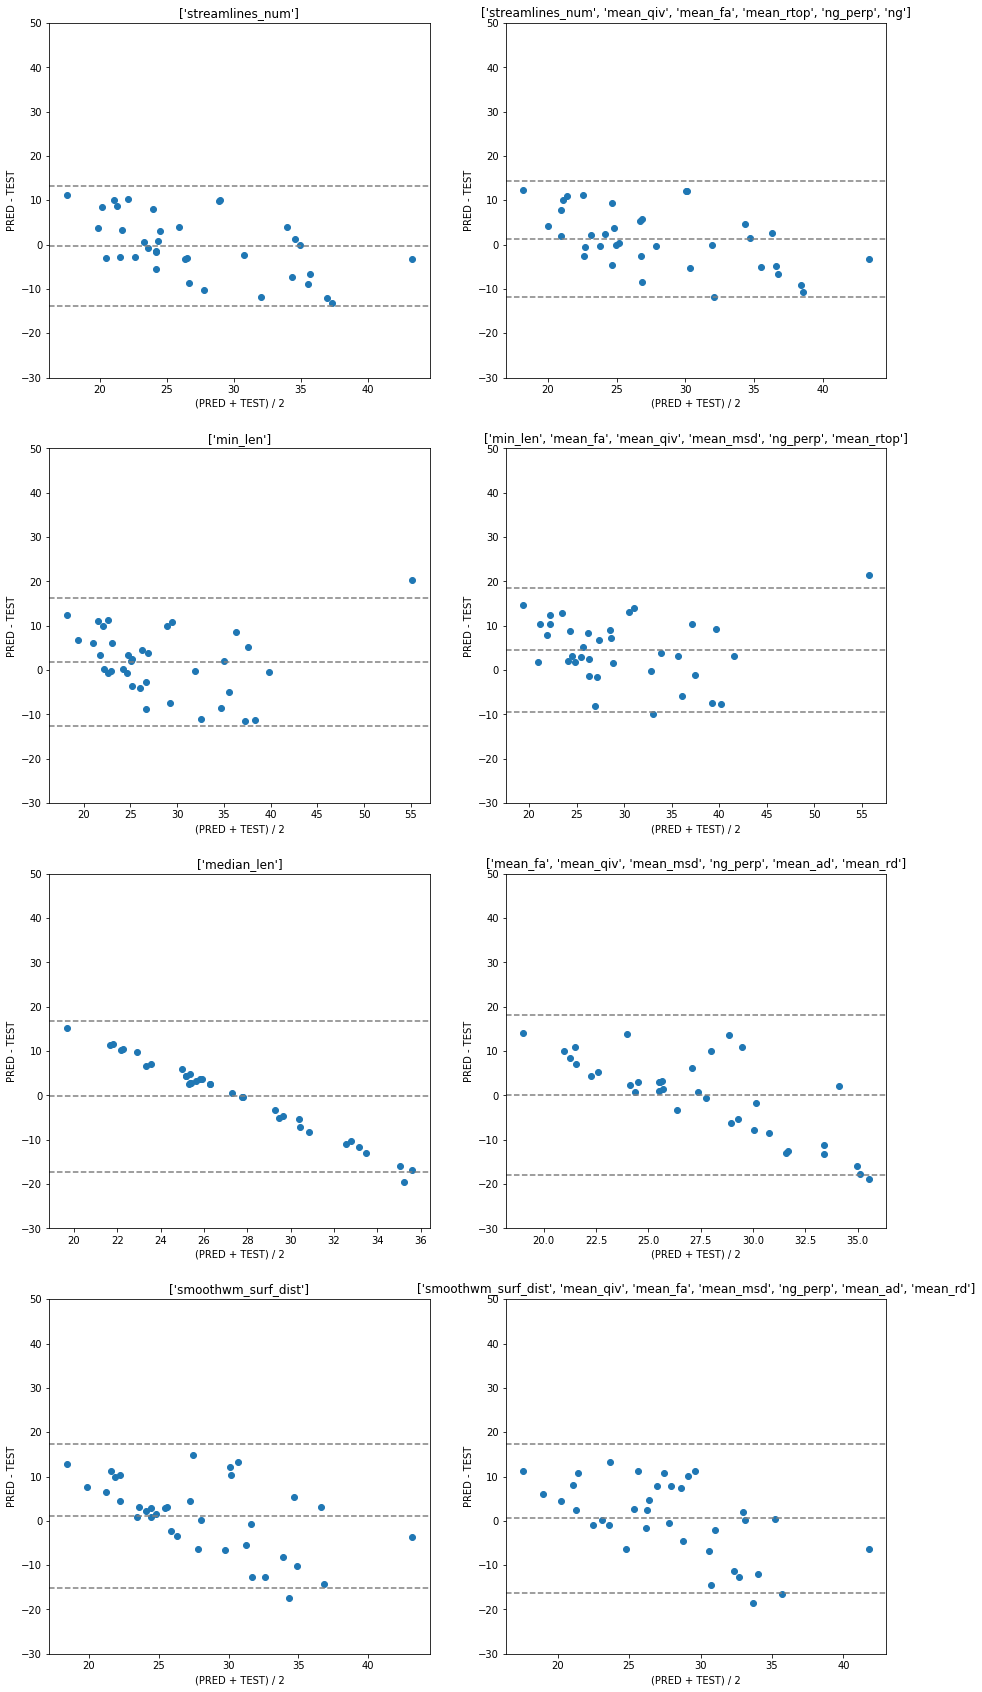

In [10]:
prediction_summary(effective_conn_measures[0])

# Prediction of P1 amplitudes


Trained on Patients: [4, 6, 7], Tested on Patients: [1]
   score  rmse  rmse_std                features
0   0.20   6.0       7.0     ['streamlines_num']
1   0.33   6.0       7.0             ['min_len']
2   0.00   7.0       8.0          ['median_len']
3   0.13   6.0       8.0  ['smoothwm_surf_dist']
   score  rmse  rmse_std                                           features
0  -0.38   8.0       8.0  ['streamlines_num', 'mean_fa', 'mean_msd', 'me...
1   0.14   6.0       7.0  ['min_len', 'mean_fa', 'mean_rd', 'ng_par', 'n...
2  -0.18   7.0       9.0  ['mean_rtpp', 'median_len', 'mean_fa', 'mean_r...
3  -1.25  10.0      10.0  ['smoothwm_surf_dist', 'mean_fa', 'mean_msd', ...

Trained on Patients: [1, 6, 7], Tested on Patients: [4]
   score  rmse  rmse_std                features
0  -0.10   7.0       8.0     ['streamlines_num']
1   0.01   7.0       8.0             ['min_len']
2   0.03   7.0       8.0          ['median_len']
3  -0.02   7.0       9.0  ['smoothwm_surf_dist']
   score  rmse  

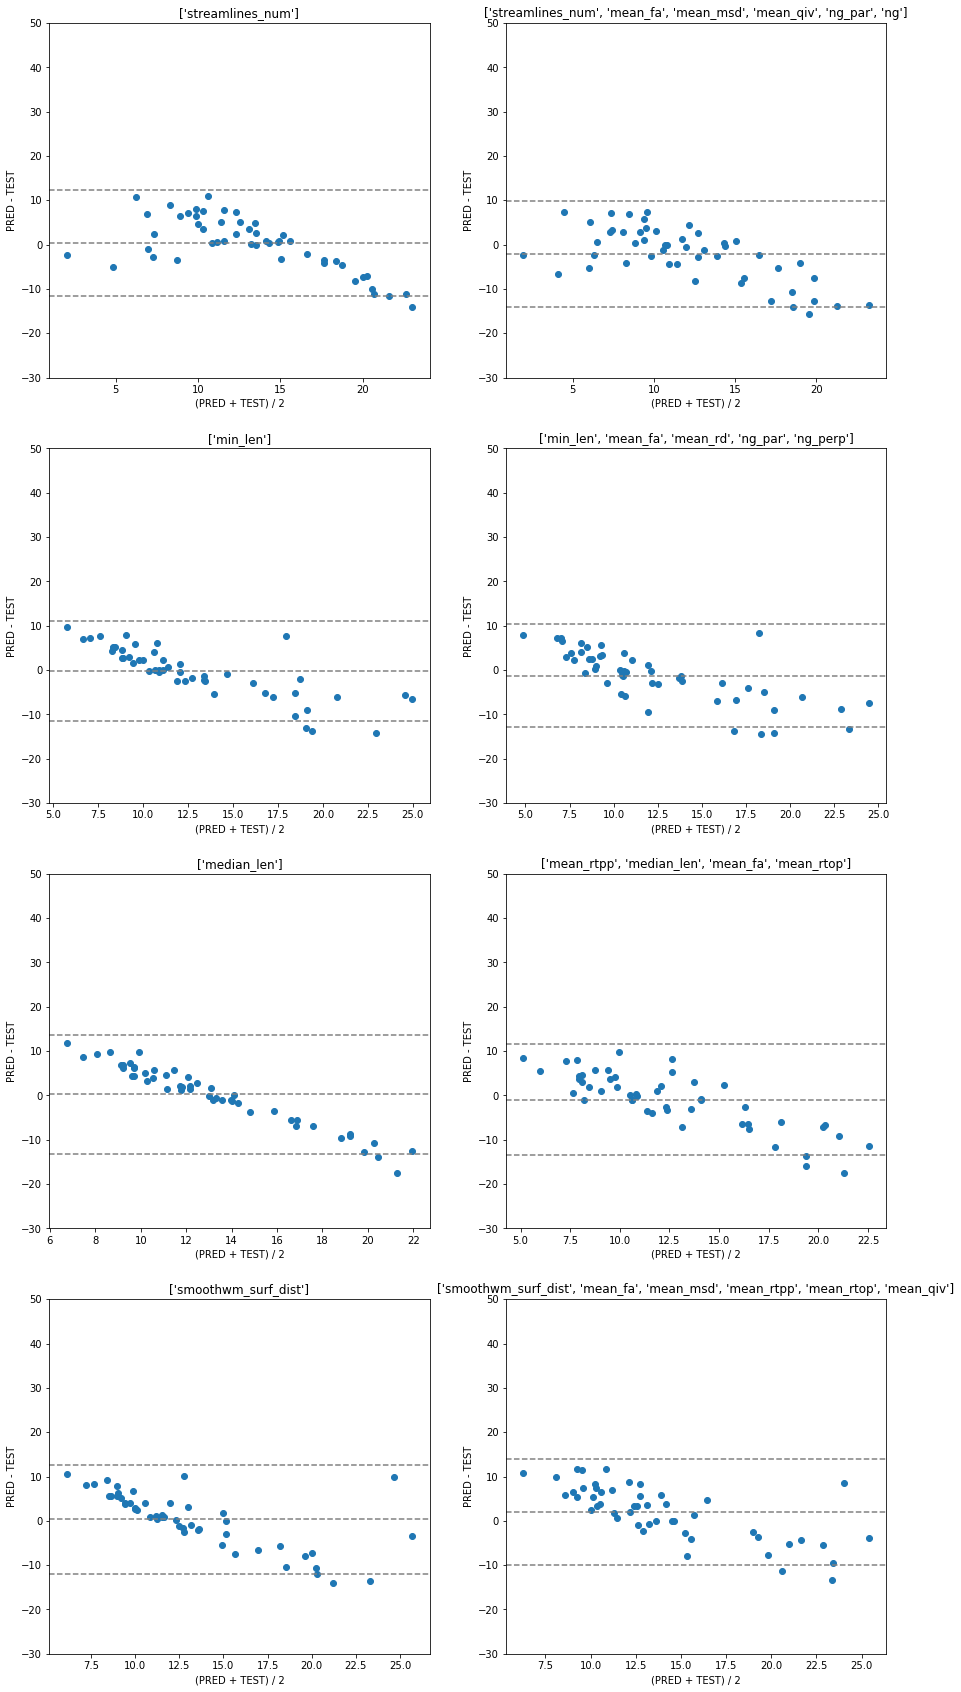

In [17]:
prediction_summary(effective_conn_measures[1])